In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2023-11-05 15:45:03.643158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 15:45:03.914354: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
def get_min(Ref, Array):
    return np.argmin(np.abs(Ref - Array))

In [3]:
ReadList = ["Mass", "evt_trig",
        "fourjetmasstev", "Mjj_avg_dRpairing_GeV",

        "Mjj_msortedP1_high_div4jm", "Mjj_msortedP1_low_div4jm",
        "Mjj_msortedP2_high_div4jm", "Mjj_msortedP2_low_div4jm",
        "Mjj_msortedP3_high_div4jm", "Mjj_msortedP3_low_div4jm",

        "P1high_MTeV", "P1low_MTeV",
        "P2high_MTeV", "P2low_MTeV",
        "P3high_MTeV", "P3low_MTeV",

        "P1_omega", "P2_omega", "P3_omega",
        "P1_x", "P2_x", "P3_x"]

In [4]:
def add_more_cols(DF):
    DF["P1high_M"] = DF["P1high_MTeV"] * 1000
    DF["P1low_M"] = DF["P1low_MTeV"] * 1000
    DF["P2high_M"] = DF["P2high_MTeV"] * 1000
    DF["P2low_M"] = DF["P2low_MTeV"] * 1000
    DF["P3high_M"] = DF["P3high_MTeV"] * 1000
    DF["P3low_M"] = DF["P3low_MTeV"] * 1000
    
    DF["P1M"] = (DF["P1high_M"] + DF["P1low_M"]) / 2
    DF["P2M"] = (DF["P2high_M"] + DF["P2low_M"]) / 2
    DF["P3M"] = (DF["P3high_M"] + DF["P3low_M"]) / 2
    
    DF["dRi"] = DF.apply(lambda row: get_min(row["Mjj_avg_dRpairing_GeV"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    DF["Truth_high"] = DF.apply(lambda row: get_min(row["Mass"],
                                np.array([row["P1high_M"], row["P2high_M"], row["P3high_M"]])), axis = 1)
    DF["Truth_avg"] = DF.apply(lambda row: get_min(row["Mass"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    
    DF["P1QSMD"] = (DF["P1high_M"] - DF["Mass"])**2 + (DF["P1low_M"] - DF["Mass"])**2
    DF["P2QSMD"] = (DF["P2high_M"] - DF["Mass"])**2 + (DF["P2low_M"] - DF["Mass"])**2
    DF["P3QSMD"] = (DF["P3high_M"] - DF["Mass"])**2 + (DF["P3low_M"] - DF["Mass"])**2
    
    DF["Truth_QSMD"] = DF.apply(lambda row: get_min(0, 
                                np.array([row["P1QSMD"], row["P2QSMD"], row["P3QSMD"]])), axis = 1)

In [5]:
def make_training_and_testing_pd(Mass):
    TrainingRows = 100000
    TestingRows = 50000
    File = "ML_TTree/tree_ML_MCRun2_" + str(Mass) + "GeV.root"
    
    print("Processing file: " + File + "\n")
    Events = uproot.open(File)["tree_ML"]
    DF = Events.arrays(ReadList, library="pd")
    
    DF = DF.loc[DF["evt_trig"] == 1].reset_index(drop=True)
    
    add_more_cols(DF)
    
    TrainingDF = DF.loc[0:TrainingRows-1]
    TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
    
    return [TrainingDF, TestingDF]

In [6]:
Masses = [500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2500, 3000]

SanityCheckPlots = False

In [7]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, Masses)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root




Processing file: ML_TTree/tree_ML_MCRun2_1250GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1750GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_3000GeV.root

Memory used: 1.00299072265625GB


In [8]:
#remove a mass point in training and check its performace in testing
#TrainingDF = TrainingDF.loc[TrainingDF["Mass"] != 3000]
TrainingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,Mjj_msortedP1_high_div4jm,Mjj_msortedP1_low_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP2_low_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP3_low_div4jm,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1_omega,P2_omega,P3_omega,P1_x,P2_x,P3_x,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD
0,500,1,1.437438,498.926239,0.589512,0.230064,0.483189,0.358433,0.372651,0.321537,0.847387,0.330702,0.694555,0.515225,0.535663,0.462190,0.105682,0.533862,0.487239,0.220143,0.188182,0.440531,847.386945,330.702499,694.554697,515.224642,535.662752,462.189755,589.044722,604.889669,498.926253,2,2,2,1.493393e+05,3.808332e+04,2.701446e+03,2
1,500,1,1.372216,564.356628,0.731474,0.091073,0.360959,0.350978,0.326251,0.315402,1.003741,0.124972,0.495314,0.481617,0.447687,0.432799,0.111787,0.088278,0.068968,0.215735,0.404618,0.558476,1003.740833,124.972475,495.314189,481.617453,447.686767,432.799034,564.356654,488.465821,440.242900,0,1,1,3.944005e+05,3.598749e+02,7.252644e+03,1
2,500,1,2.415887,681.370911,0.773636,0.146419,0.421770,0.200474,0.326372,0.237703,1.869017,0.353732,1.018949,0.484321,0.788478,0.574264,0.007358,0.765636,0.753072,0.086891,0.607087,0.772813,1869.017332,353.732193,1018.949055,484.321434,788.477532,574.264262,1111.374763,751.635244,681.370897,2,2,2,1.895603e+06,2.695539e+05,8.873447e+04,2
3,500,1,1.927872,706.945679,0.589096,0.333414,0.496342,0.237053,0.458295,0.177519,1.135702,0.642779,0.956883,0.457008,0.883534,0.342234,0.260263,0.245321,0.727504,0.083999,0.363522,0.572786,1135.701841,642.779060,956.883294,457.008091,883.534240,342.234189,889.240451,706.945693,612.884215,1,2,2,4.245027e+05,2.105906e+05,1.719886e+05,2
4,500,1,1.149871,290.337799,0.741729,0.126430,0.417437,0.357386,0.325977,0.179015,0.852893,0.145379,0.479999,0.410948,0.374831,0.205845,0.167786,0.022979,0.097892,0.151862,0.290617,0.980230,852.893143,145.378714,479.999201,410.947632,374.831089,205.844503,499.135929,445.473416,290.337796,2,1,0,2.502898e+05,8.330356e+03,1.021947e+05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,3000,1,5.470423,1425.474121,0.777138,0.043360,0.448219,0.084825,0.424968,0.096188,4.251276,0.237198,2.451948,0.464031,2.324757,0.526192,0.001141,0.260099,0.230056,0.218771,0.876016,0.918808,4251.275721,237.198071,2451.948205,464.031226,2324.756583,526.191613,2244.236896,1457.989716,1425.474098,2,1,0,9.198765e+06,6.731498e+06,6.575682e+06,2
1199996,3000,1,5.158958,887.806580,0.643059,0.304304,0.572051,0.326478,0.216002,0.128179,3.317512,1.569893,2.951189,1.684289,1.114346,0.661268,0.030534,0.246707,0.093194,0.055562,0.112929,1.905452,3317.512357,1569.892799,2951.189007,1684.288998,1114.345603,661.267596,2443.702578,2317.739002,887.806600,2,1,0,2.146021e+06,1.733478e+06,9.025362e+06,1
1199997,3000,1,6.064116,2136.975586,0.491871,0.428915,0.475817,0.269271,0.474886,0.229907,2.982766,2.600989,2.885411,1.632892,2.879766,1.394185,0.316123,0.660434,0.210472,0.086028,0.342123,0.418855,2982.765773,2600.989495,2885.410885,1632.891581,2879.766141,1394.184799,2791.877634,2259.151233,2136.975470,2,0,0,1.595064e+05,1.882116e+06,2.593099e+06,0
1199998,3000,1,5.248789,1548.930664,0.540463,0.328184,0.491500,0.098705,0.476322,0.358619,2.836779,1.722566,2.579780,0.518081,2.500116,1.882315,0.038156,0.314566,0.239075,0.151215,0.694327,0.197689,2836.778533,1722.566455,2579.780436,518.080806,2500.115766,1882.314500,2279.672494,1548.930621,2191.215133,1,0,0,1.658478e+06,6.336507e+06,1.499105e+06,2


In [9]:
TrainingDF.dtypes

Mass                           int32
evt_trig                       int32
fourjetmasstev               float64
Mjj_avg_dRpairing_GeV        float32
Mjj_msortedP1_high_div4jm    float64
Mjj_msortedP1_low_div4jm     float64
Mjj_msortedP2_high_div4jm    float64
Mjj_msortedP2_low_div4jm     float64
Mjj_msortedP3_high_div4jm    float64
Mjj_msortedP3_low_div4jm     float64
P1high_MTeV                  float64
P1low_MTeV                   float64
P2high_MTeV                  float64
P2low_MTeV                   float64
P3high_MTeV                  float64
P3low_MTeV                   float64
P1_omega                     float64
P2_omega                     float64
P3_omega                     float64
P1_x                         float64
P2_x                         float64
P3_x                         float64
P1high_M                     float64
P1low_M                      float64
P2high_M                     float64
P2low_M                      float64
P3high_M                     float64
P

In [10]:
if SanityCheckPlots:
    plt.hist(TrainingDF["Mass"], bins = int((Masses[-1] - Masses[0])/50) + 1,
             range = [Masses[0]-25, Masses[-1]+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Training Sample")

In [11]:
if SanityCheckPlots:
    plt.hist(TestingDF["Mass"], bins = int((Masses[-1] - Masses[0])/50) + 1,
             range = [Masses[0]-25, Masses[-1]+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Testing Sample")

In [12]:
InputList = ["fourjetmasstev"]

InputList += ["P1high_MTeV", "P1low_MTeV",
              "P2high_MTeV", "P2low_MTeV",
              "P3high_MTeV", "P3low_MTeV"]

#InputList += ["Mjj_msortedP1_high_div4jm", "Mjj_msortedP1_low_div4jm",
#             "Mjj_msortedP2_high_div4jm", "Mjj_msortedP2_low_div4jm",
#             "Mjj_msortedP3_high_div4jm", "Mjj_msortedP3_low_div4jm"]

#InputList += ["P1_omega", "P2_omega", "P3_omega"]
#InputList += ["P1_x", "P2_x", "P3_x"]

TrainingInputs = TrainingDF[InputList].to_numpy()
TrainingTruth = TrainingDF["Truth_QSMD"].to_numpy()

TestingInputs = TestingDF[InputList].to_numpy()

In [13]:
print(TrainingInputs.shape)
print(TrainingTruth.shape)
print(TestingInputs.shape)

(1200000, 7)
(1200000,)
(600000, 7)


In [14]:
NotebookName = "quad_sum_mass_diff_DNN_Dropout_0p2_MTeV"
ResultsDir = "results_temp/results_" + NotebookName + "/"
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

In [15]:
def model_DNN_L1L2():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(len(InputList), ), name="model_in"),
        tf.keras.layers.Dense(32, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.005, l2=0.001)),
        tf.keras.layers.Dense(16, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.005, l2=0.001)),
        tf.keras.layers.Dense(8, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.005, l2=0.001)),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelDNNL1L2"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [16]:
def model_DNN_Dropout():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(len(InputList), ), name="model_in"),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelDNNDropout"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [17]:
#Model = model_DNN_L1L2()
Model = model_DNN_Dropout()

2023-11-05 15:46:25.145164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 15:46:25.847078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11311 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


In [18]:
Model.summary()

Model: "ModelDNNDropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 model_out (Dense)           (None, 3)             

In [19]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(ResultsDir + "Model.h5", save_best_only = True, monitor = "val_loss", mode = "min")

History = Model.fit(TrainingInputs, TrainingTruth, batch_size = 5000,
                    epochs = 50, validation_split = 0.2, callbacks=[checkpoint])

Epoch 1/50
192/192 [==============================] - 2s 5ms/step - loss: 1.0110 - accuracy: 0.5220 - val_loss: 0.7541 - val_accuracy: 0.6590
Epoch 2/50
192/192 [==============================] - 1s 3ms/step - loss: 0.7953 - accuracy: 0.6707 - val_loss: 0.5917 - val_accuracy: 0.7165
Epoch 3/50
192/192 [==============================] - 1s 3ms/step - loss: 0.6908 - accuracy: 0.7126 - val_loss: 0.5006 - val_accuracy: 0.8005
Epoch 4/50
192/192 [==============================] - 1s 3ms/step - loss: 0.6385 - accuracy: 0.7353 - val_loss: 0.4885 - val_accuracy: 0.8029
Epoch 5/50
192/192 [==============================] - 1s 3ms/step - loss: 0.6159 - accuracy: 0.7443 - val_loss: 0.4674 - val_accuracy: 0.8133
Epoch 6/50
192/192 [==============================] - 0s 3ms/step - loss: 0.5982 - accuracy: 0.7497 - val_loss: 0.4813 - val_accuracy: 0.8044
Epoch 7/50
192/192 [==============================] - 1s 3ms/step - loss: 0.5854 - accuracy: 0.7542 - val_loss: 0.4567 - val_accuracy: 0.8181
Epoch 

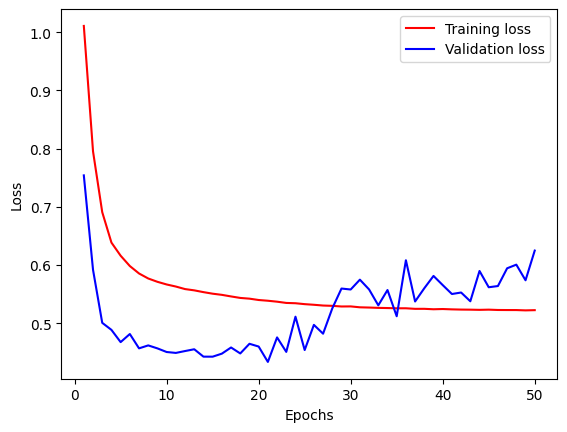

In [20]:
Loss = History.history["loss"]
ValLoss = History.history["val_loss"]
Epochs = range(1, len(Loss) + 1)

plt.plot(Epochs, Loss, "r", label="Training loss")
plt.plot(Epochs, ValLoss, "b", label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
    
plt.savefig(ResultsDir + "Loss_vs_Epochs.png")

In [21]:
#Model.save(ResultsDir + "Model.h5")

ModelTest = tf.keras.models.load_model(ResultsDir + "Model.h5")
TestingOutputs = ModelTest.predict(TestingInputs, batch_size = 5000)

120/120 [==============================] - 0s 1ms/step


In [22]:
TestingOutputs[0] #ML raw output is the probability of 3 sparse categories

array([0.00107503, 0.77370024, 0.22522469], dtype=float32)

In [23]:
TestingPredictions = np.argmax(TestingOutputs, axis = 1) #pick the highest probability as ML output

In [24]:
print(TestingPredictions.shape)
print(TestingPredictions[0])

(600000,)
1


In [25]:
TestingDF["Pred"] = TestingPredictions.tolist()

In [26]:
TestingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,Mjj_msortedP1_high_div4jm,Mjj_msortedP1_low_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP2_low_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP3_low_div4jm,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1_omega,P2_omega,P3_omega,P1_x,P2_x,P3_x,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred
0,500,1,1.665246,569.138611,0.650471,0.224561,0.406185,0.367549,0.366546,0.317003,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.046210,0.052917,0.390874,0.142816,0.292434,0.462953,1083.193410,373.949755,676.398680,612.058930,610.389668,527.887546,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,1
1,500,1,1.109070,235.760468,0.634266,0.338461,0.448905,0.422055,0.308877,0.116273,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.105361,0.023965,0.015567,0.028038,0.148158,1.352112,703.445644,375.376717,497.867207,468.088484,342.566192,128.954730,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,1
2,500,1,1.522245,473.871796,0.581316,0.391682,0.488398,0.288164,0.337147,0.285449,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.169850,0.400204,0.160783,0.027751,0.287727,0.606178,884.905691,596.236004,743.460797,438.656782,513.219915,434.523672,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,2
3,500,1,2.525532,472.603851,0.859122,0.105092,0.317233,0.258081,0.278710,0.095551,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.216939,0.231292,0.066363,0.037114,0.738182,1.671933,2169.740485,265.412339,801.180826,651.791965,703.891486,241.316244,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,1
4,500,1,1.569428,567.971130,0.596522,0.127271,0.572933,0.307751,0.326371,0.318654,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.279489,0.064446,0.102583,0.381609,0.135481,0.550328,936.198882,199.743343,899.176959,482.993652,512.215294,500.104844,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,3000,1,6.142254,2605.686768,0.606728,0.348323,0.425973,0.422473,0.348761,0.173518,3.726679,2.139488,2.616437,2.594937,2.142181,1.065793,0.043104,0.257787,0.851269,0.047064,0.178625,0.914684,3726.679280,2139.487545,2616.436654,2594.936898,2142.180822,1065.792656,2933.083412,2605.686776,1603.986739,1,1,0,1.268544e+06,3.111970e+05,4.477012e+06,1,1
599996,3000,1,5.129152,1248.353516,0.545517,0.372867,0.475153,0.414260,0.400566,0.086202,2.798038,1.912490,2.437130,2.124802,2.054564,0.442143,0.081672,0.338283,0.653166,0.088870,0.124338,1.054367,2798.037987,1912.490264,2437.130249,2124.802439,2054.564499,442.142653,2355.264125,2280.966344,1248.353576,2,0,0,1.223466e+06,1.082793e+06,7.436482e+06,1,1
599997,3000,1,6.280539,1231.659424,0.720415,0.244488,0.525028,0.264583,0.214241,0.177973,4.524592,1.535514,3.297457,1.661724,1.345551,1.117768,0.162941,0.630162,0.744355,0.036374,0.266447,1.549625,4524.592364,1535.514102,3297.457153,1661.724282,1345.551306,1117.767633,3030.053233,2479.590718,1231.659470,2,1,0,4.469101e+06,1.879463e+06,6.279999e+06,1,2
599998,3000,1,6.048077,1822.411743,0.521897,0.336823,0.475347,0.451308,0.354163,0.248479,3.156473,2.037133,2.874936,2.729543,2.142006,1.502817,0.464930,0.141489,0.216246,0.164524,0.079151,0.659361,3156.472845,2037.132867,2874.936016,2729.542849,2142.006216,1502.817188,2596.802856,2802.239432,1822.411702,2,1,1,9.515969e+05,8.878807e+04,2.977710e+06,1,1


In [27]:
AccPred = []
AccdR = []
Acc0 = []
Acc1 = []
Acc2 = []
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    TestingDF_pred = TestingDF_temp.loc[TestingDF_temp["Pred"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_dR = TestingDF_temp.loc[TestingDF_temp["dRi"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_0 = TestingDF_temp.loc[0==TestingDF_temp["Truth_QSMD"]]
    TestingDF_1 = TestingDF_temp.loc[1==TestingDF_temp["Truth_QSMD"]]
    TestingDF_2 = TestingDF_temp.loc[2==TestingDF_temp["Truth_QSMD"]]

    AccPred.append(float(len(TestingDF_pred.index))/len(TestingDF_temp.index))
    AccdR.append(float(len(TestingDF_dR.index))/len(TestingDF_temp.index))
    Acc0.append(float(len(TestingDF_0.index))/len(TestingDF_temp.index))
    Acc1.append(float(len(TestingDF_1.index))/len(TestingDF_temp.index))
    Acc2.append(float(len(TestingDF_2.index))/len(TestingDF_temp.index))

In [28]:
AccPredAvg = "Avg %.2f" % float(sum(AccPred)/len(AccPred))
AccdRAvg = "Avg %.2f" % float(sum(AccdR)/len(AccdR))
Acc0Avg = "Avg %.2f" % float(sum(Acc0)/len(Acc0))
Acc1Avg = "Avg %.2f" % float(sum(Acc1)/len(Acc1))
Acc2Avg = "Avg %.2f" % float(sum(Acc2)/len(Acc2))

print(["%.2f" % i for i in AccPred], AccPredAvg)
print(["%.2f" % i for i in AccdR], AccdRAvg)
print(["%.2f" % i for i in Acc0], Acc0Avg)
print(["%.2f" % i for i in Acc1], Acc1Avg)
print(["%.2f" % i for i in Acc2], Acc2Avg)

['0.63', '0.75', '0.79', '0.80', '0.81', '0.82', '0.82', '0.83', '0.84', '0.84', '0.85', '0.81'] Avg 0.80
['0.40', '0.26', '0.20', '0.18', '0.16', '0.14', '0.12', '0.11', '0.11', '0.11', '0.10', '0.07'] Avg 0.16
['0.04', '0.10', '0.14', '0.15', '0.16', '0.18', '0.19', '0.20', '0.19', '0.19', '0.17', '0.16'] Avg 0.16
['0.30', '0.41', '0.44', '0.45', '0.47', '0.48', '0.50', '0.51', '0.51', '0.51', '0.51', '0.54'] Avg 0.47
['0.65', '0.49', '0.43', '0.39', '0.36', '0.35', '0.31', '0.30', '0.29', '0.30', '0.32', '0.29'] Avg 0.37


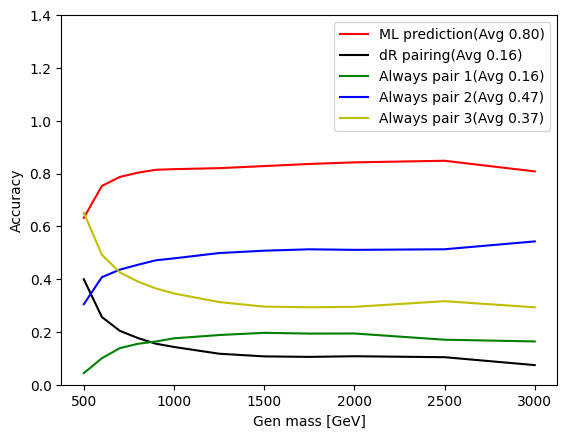

In [29]:
plt.plot(Masses, AccPred, "r", label = "ML prediction(" + AccPredAvg + ")")
plt.plot(Masses, AccdR, "k", label = "dR pairing(" + AccdRAvg + ")")
plt.plot(Masses, Acc0, "g", label = "Always pair 1(" + Acc0Avg + ")")
plt.plot(Masses, Acc1, "b", label = "Always pair 2(" + Acc1Avg + ")")
plt.plot(Masses, Acc2, "y", label = "Always pair 3(" + Acc2Avg + ")")
plt.legend()
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.ylim(0, 1.4)
plt.savefig(ResultsDir + "Accuracy_vs_mass.png")

In [30]:
P1Mi = TestingDF.columns.get_loc("P1M")
#TestingDF["dR_M"] = TestingDF.apply(lambda row: row.iloc[row["dRi"]], axis=1)
TestingDF["dR_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["dRi"]]
TestingDF["Truth_high_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_avg"]]
TestingDF["Pred_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Pred"]]
TestingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,Mjj_msortedP1_high_div4jm,Mjj_msortedP1_low_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP2_low_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP3_low_div4jm,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1_omega,P2_omega,P3_omega,P1_x,P2_x,P3_x,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M
0,500,1,1.665246,569.138611,0.650471,0.224561,0.406185,0.367549,0.366546,0.317003,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.046210,0.052917,0.390874,0.142816,0.292434,0.462953,1083.193410,373.949755,676.398680,612.058930,610.389668,527.887546,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,1,569.138607,569.138607,569.138607,644.228805
1,500,1,1.109070,235.760468,0.634266,0.338461,0.448905,0.422055,0.308877,0.116273,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.105361,0.023965,0.015567,0.028038,0.148158,1.352112,703.445644,375.376717,497.867207,468.088484,342.566192,128.954730,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,1,235.760461,482.977846,482.977846,482.977846
2,500,1,1.522245,473.871796,0.581316,0.391682,0.488398,0.288164,0.337147,0.285449,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.169850,0.400204,0.160783,0.027751,0.287727,0.606178,884.905691,596.236004,743.460797,438.656782,513.219915,434.523672,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,2,473.871794,473.871794,473.871794,473.871794
3,500,1,2.525532,472.603851,0.859122,0.105092,0.317233,0.258081,0.278710,0.095551,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.216939,0.231292,0.066363,0.037114,0.738182,1.671933,2169.740485,265.412339,801.180826,651.791965,703.891486,241.316244,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,1,472.603865,472.603865,472.603865,726.486396
4,500,1,1.569428,567.971130,0.596522,0.127271,0.572933,0.307751,0.326371,0.318654,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.279489,0.064446,0.102583,0.381609,0.135481,0.550328,936.198882,199.743343,899.176959,482.993652,512.215294,500.104844,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,2,567.971112,506.160069,506.160069,506.160069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,3000,1,6.142254,2605.686768,0.606728,0.348323,0.425973,0.422473,0.348761,0.173518,3.726679,2.139488,2.616437,2.594937,2.142181,1.065793,0.043104,0.257787,0.851269,0.047064,0.178625,0.914684,3726.679280,2139.487545,2616.436654,2594.936898,2142.180822,1065.792656,2933.083412,2605.686776,1603.986739,1,1,0,1.268544e+06,3.111970e+05,4.477012e+06,1,1,2605.686776,2605.686776,2933.083412,2605.686776
599996,3000,1,5.129152,1248.353516,0.545517,0.372867,0.475153,0.414260,0.400566,0.086202,2.798038,1.912490,2.437130,2.124802,2.054564,0.442143,0.081672,0.338283,0.653166,0.088870,0.124338,1.054367,2798.037987,1912.490264,2437.130249,2124.802439,2054.564499,442.142653,2355.264125,2280.966344,1248.353576,2,0,0,1.223466e+06,1.082793e+06,7.436482e+06,1,1,1248.353576,2355.264125,2355.264125,2280.966344
599997,3000,1,6.280539,1231.659424,0.720415,0.244488,0.525028,0.264583,0.214241,0.177973,4.524592,1.535514,3.297457,1.661724,1.345551,1.117768,0.162941,0.630162,0.744355,0.036374,0.266447,1.549625,4524.592364,1535.514102,3297.457153,1661.724282,1345.551306,1117.767633,3030.053233,2479.590718,1231.659470,2,1,0,4.469101e+06,1.879463e+06,6.279999e+06,1,2,1231.659470,2479.590718,3030.053233,1231.659470
599998,3000,1,6.048077,1822.411743,0.521897,0.336823,0.475347,0.451308,0.354163,0.248479,3.156473,2.037133,2.874936,2.729543,2.142006,1.502817,0.464930,0.141489,0.216246,0.164524,0.079151,0.659361,3156.472845,2037.132867,2874.93

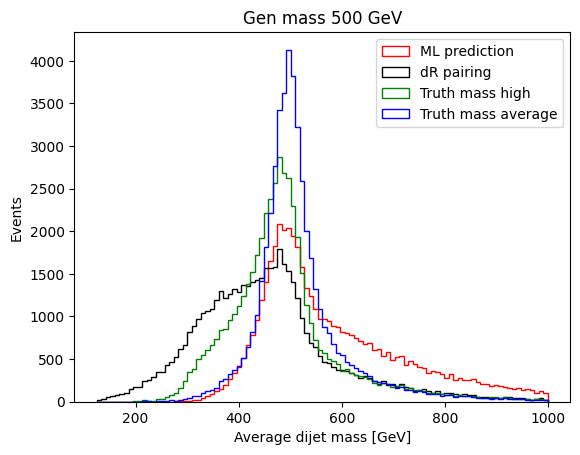

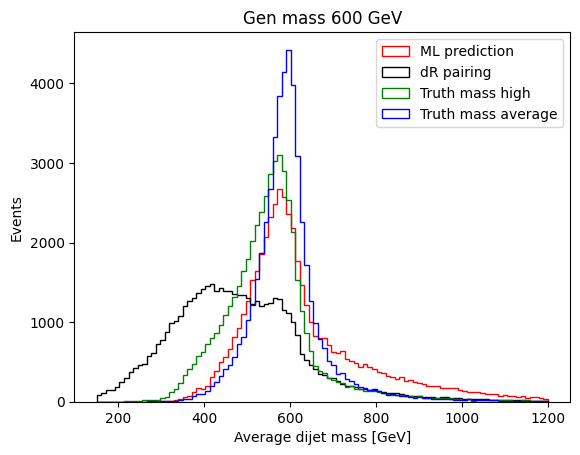

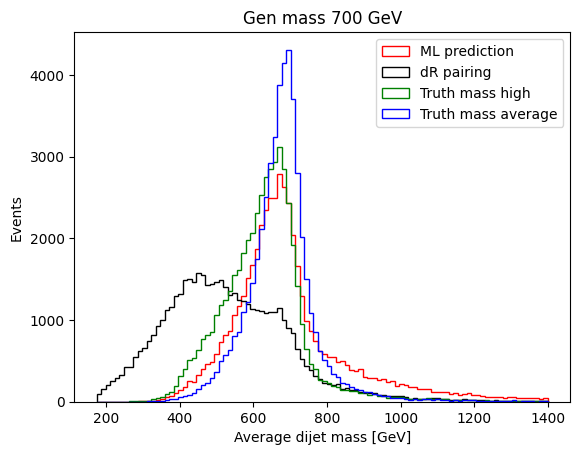

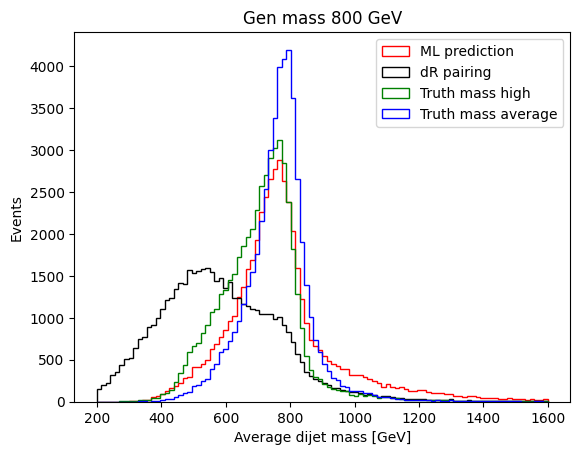

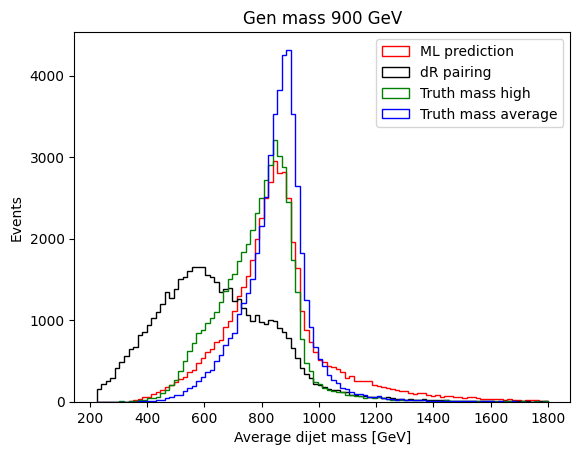

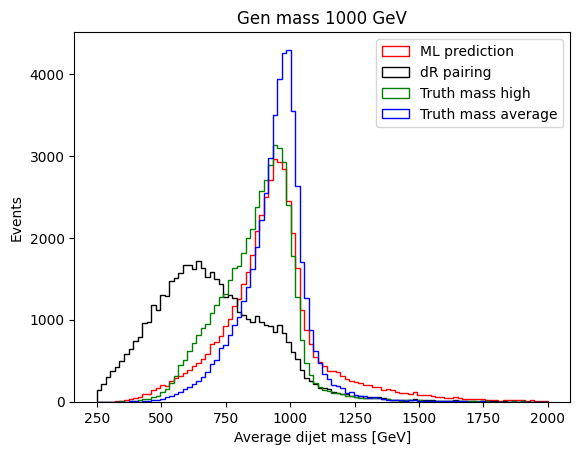

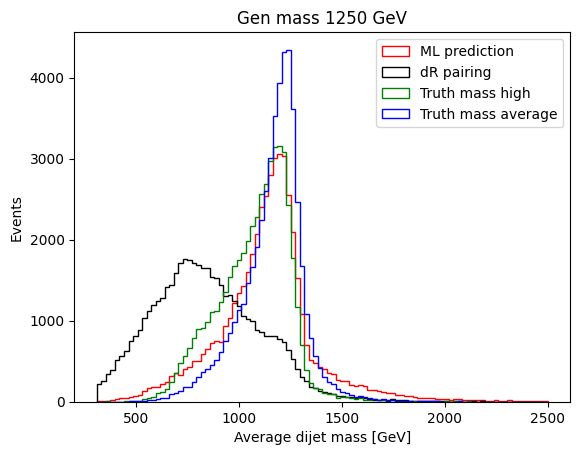

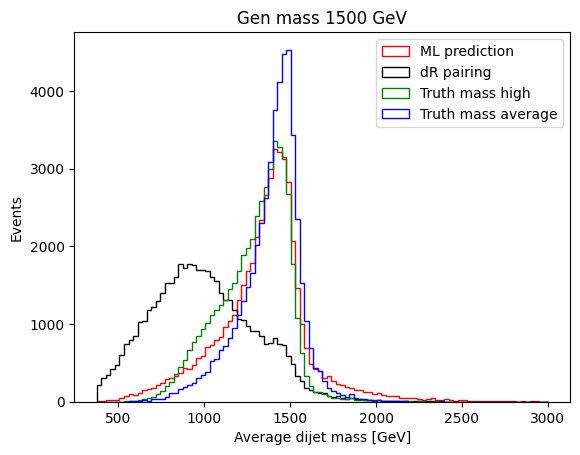

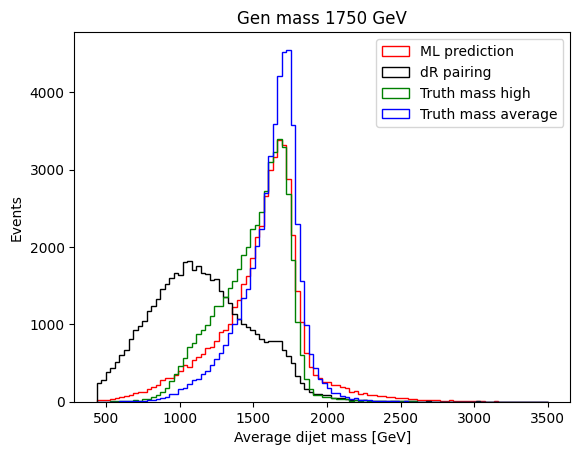

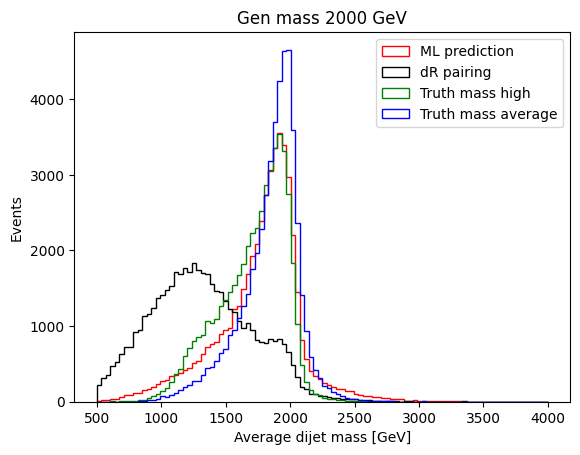

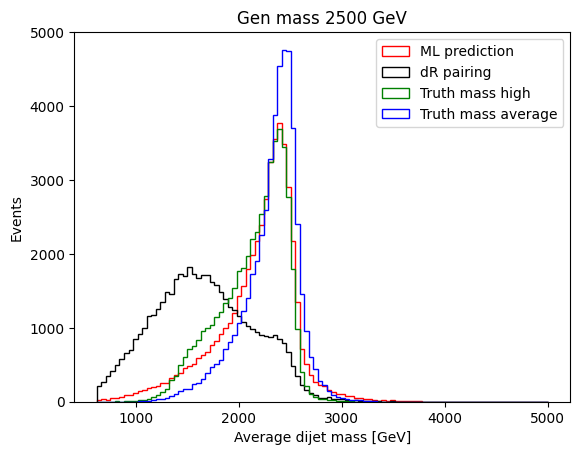

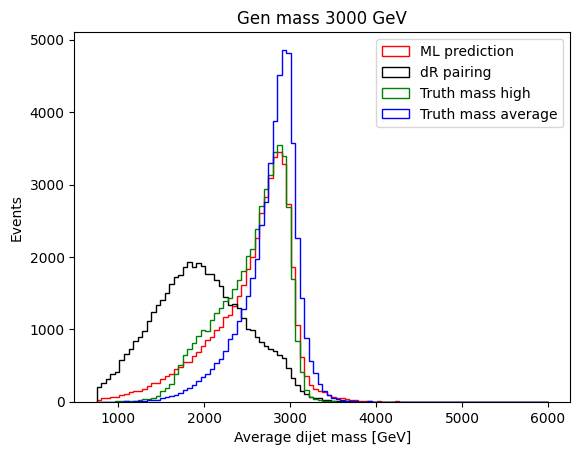

In [31]:
# for each gen mass sample, plot average dijet mass
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "b", label = "Truth mass average")
    plt.legend()
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Average dijet mass [GeV]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Average_dijet_mass_" + str(Mass) + "GeV.png")

In [32]:
P1M_high_i = TestingDF.columns.get_loc("P1high_M")
TestingDF["dR_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["dRi"]*2]
TestingDF["Truth_high_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["Truth_high"]*2]
TestingDF["Truth_avg_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["Truth_avg"]*2]
TestingDF["Pred_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["Pred"]*2]
TestingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,Mjj_msortedP1_high_div4jm,Mjj_msortedP1_low_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP2_low_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP3_low_div4jm,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1_omega,P2_omega,P3_omega,P1_x,P2_x,P3_x,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_M_high,Truth_high_M_high,Truth_avg_M_high,Pred_M_high
0,500,1,1.665246,569.138611,0.650471,0.224561,0.406185,0.367549,0.366546,0.317003,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.046210,0.052917,0.390874,0.142816,0.292434,0.462953,1083.193410,373.949755,676.398680,612.058930,610.389668,527.887546,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,1,569.138607,569.138607,569.138607,644.228805,610.389668,610.389668,610.389668,676.398680
1,500,1,1.109070,235.760468,0.634266,0.338461,0.448905,0.422055,0.308877,0.116273,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.105361,0.023965,0.015567,0.028038,0.148158,1.352112,703.445644,375.376717,497.867207,468.088484,342.566192,128.954730,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,1,235.760461,482.977846,482.977846,482.977846,342.566192,497.867207,497.867207,497.867207
2,500,1,1.522245,473.871796,0.581316,0.391682,0.488398,0.288164,0.337147,0.285449,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.169850,0.400204,0.160783,0.027751,0.287727,0.606178,884.905691,596.236004,743.460797,438.656782,513.219915,434.523672,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,2,473.871794,473.871794,473.871794,473.871794,513.219915,513.219915,513.219915,513.219915
3,500,1,2.525532,472.603851,0.859122,0.105092,0.317233,0.258081,0.278710,0.095551,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.216939,0.231292,0.066363,0.037114,0.738182,1.671933,2169.740485,265.412339,801.180826,651.791965,703.891486,241.316244,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,1,472.603865,472.603865,472.603865,726.486396,703.891486,703.891486,703.891486,801.180826
4,500,1,1.569428,567.971130,0.596522,0.127271,0.572933,0.307751,0.326371,0.318654,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.279489,0.064446,0.102583,0.381609,0.135481,0.550328,936.198882,199.743343,899.176959,482.993652,512.215294,500.104844,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,2,567.971112,506.160069,506.160069,506.160069,936.198882,512.215294,512.215294,512.215294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,3000,1,6.142254,2605.686768,0.606728,0.348323,0.425973,0.422473,0.348761,0.173518,3.726679,2.139488,2.616437,2.594937,2.142181,1.065793,0.043104,0.257787,0.851269,0.047064,0.178625,0.914684,3726.679280,2139.487545,2616.436654,2594.936898,2142.180822,1065.792656,2933.083412,2605.686776,1603.986739,1,1,0,1.268544e+06,3.111970e+05,4.477012e+06,1,1,2605.686776,2605.686776,2933.083412,2605.686776,2616.436654,2616.436654,3726.679280,2616.436654
599996,3000,1,5.129152,1248.353516,0.545517,0.372867,0.475153,0.414260,0.400566,0.086202,2.798038,1.912490,2.437130,2.124802,2.054564,0.442143,0.081672,0.338283,0.653166,0.088870,0.124338,1.054367,2798.037987,1912.490264,2437.130249,2124.802439,2054.564499,442.142653,2355.264125,2280.966344,1248.353576,2,0,0,1.223466e+06,1.082793e+06,7.436482e+06,1,1,1248.353576,2355.264125,2355.264125,2280.966344,2054.564499,2798.037987,2798.037987,2437.130249
599997,3000,1,6.280539,1231.659424,0.720415,0.244488,0.525028,0.264583,0.214241,0.177973,4.524592,1.535514,3.297457,1.661724,1.345551,1.117768,0.162941,0.630162,0.744355,0.036374,0.266447,1.549625,4524.592364,1535.514102,3297.457153,1661.724

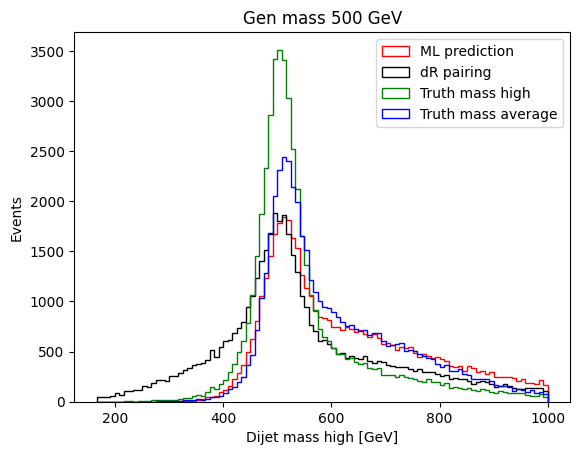

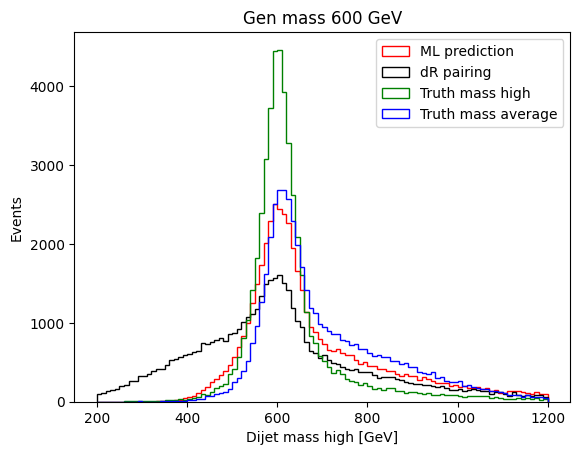

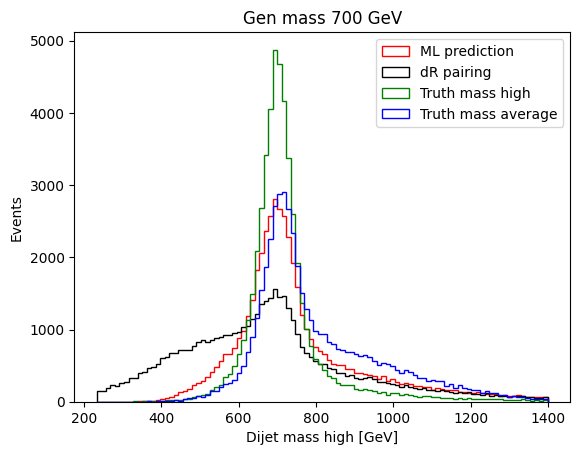

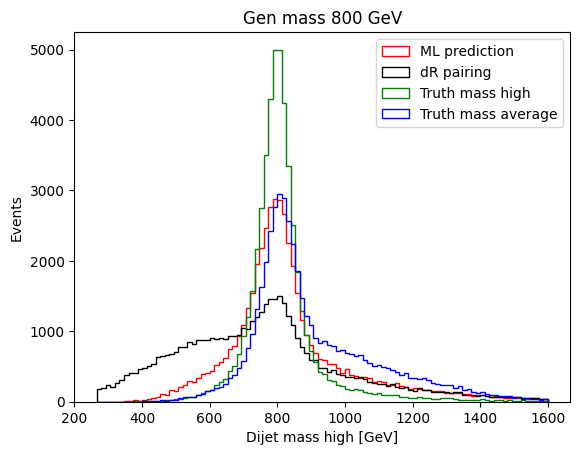

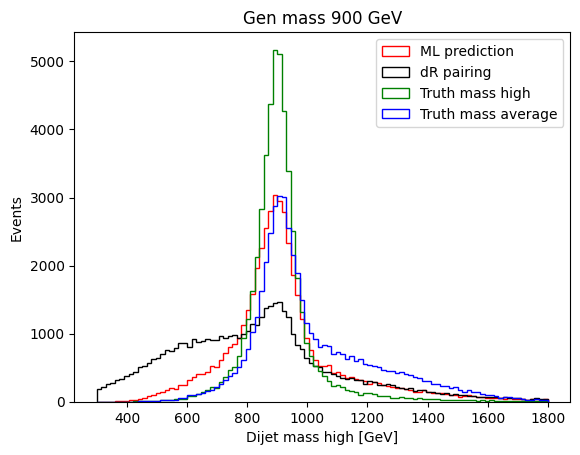

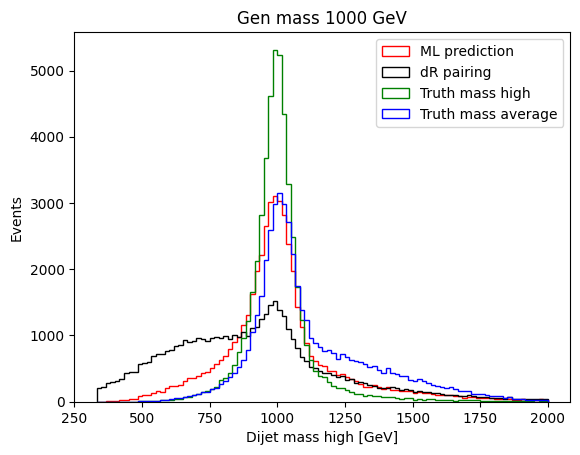

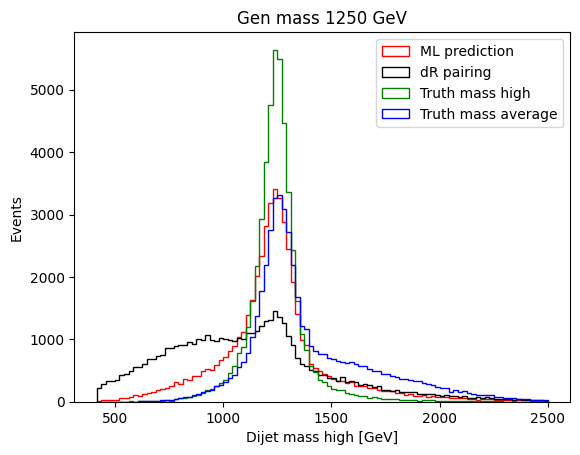

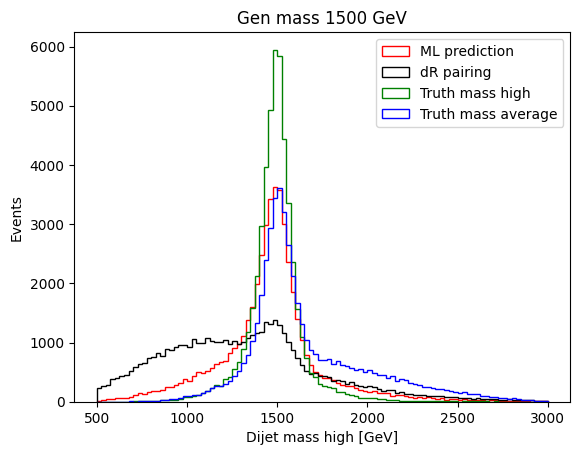

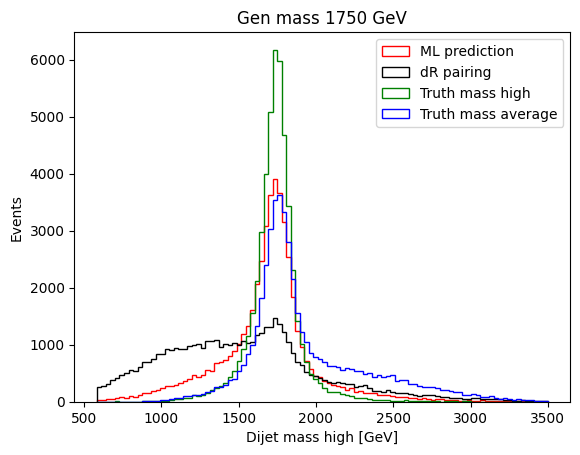

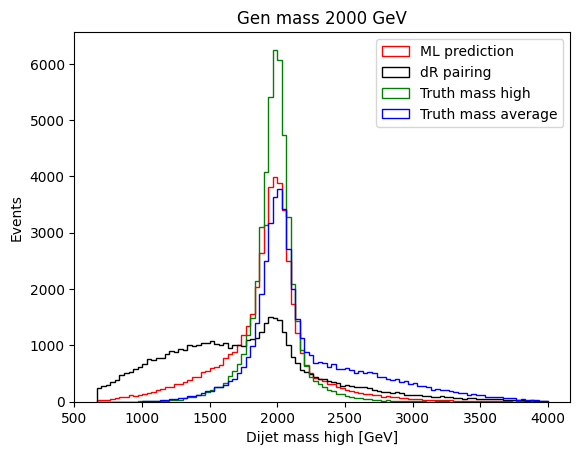

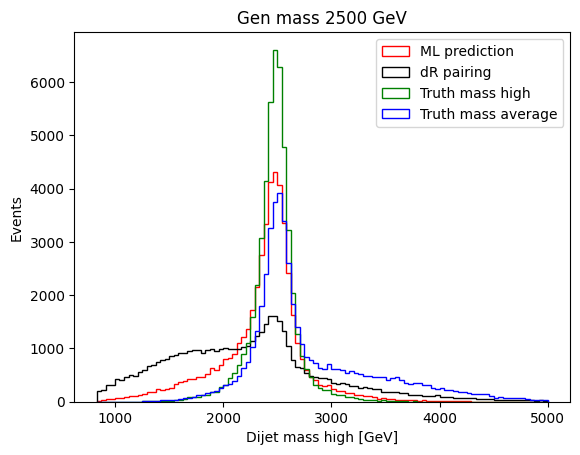

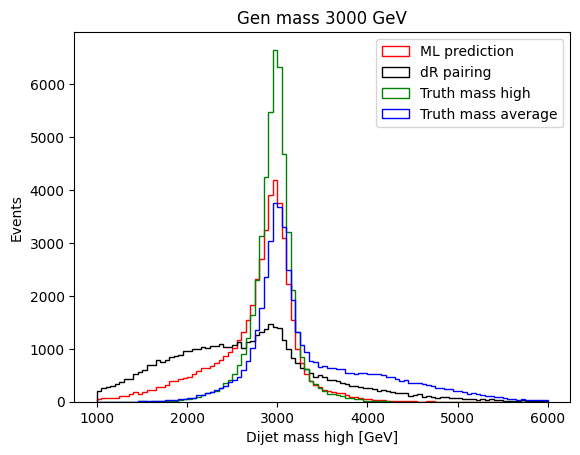

In [33]:
# for each gen mass sample, plot dijet mass high
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "b", label = "Truth mass average")
    plt.legend(loc="upper right")
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Dijet mass high [GeV]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Dijet_mass_high_" + str(Mass) + "GeV.png")

In [34]:
P1QSMDi = TestingDF.columns.get_loc("P1QSMD")
TestingDF["dR_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["dRi"]]
TestingDF["Truth_high_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_avg"]]
TestingDF["Pred_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Pred"]]
TestingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,Mjj_msortedP1_high_div4jm,Mjj_msortedP1_low_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP2_low_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP3_low_div4jm,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1_omega,P2_omega,P3_omega,P1_x,P2_x,P3_x,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_M_high,Truth_high_M_high,Truth_avg_M_high,Pred_M_high,dR_QSMD,Truth_high_QSMD,Truth_avg_QSMD,Pred_QSMD
0,500,1,1.665246,569.138611,0.650471,0.224561,0.406185,0.367549,0.366546,0.317003,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.046210,0.052917,0.390874,0.142816,0.292434,0.462953,1083.193410,373.949755,676.398680,612.058930,610.389668,527.887546,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,1,569.138607,569.138607,569.138607,644.228805,610.389668,610.389668,610.389668,676.398680,1.296359e+04,1.296359e+04,1.296359e+04,4.367370e+04
1,500,1,1.109070,235.760468,0.634266,0.338461,0.448905,0.422055,0.308877,0.116273,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.105361,0.023965,0.015567,0.028038,0.148158,1.352112,703.445644,375.376717,497.867207,468.088484,342.566192,128.954730,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,1,235.760461,482.977846,482.977846,482.977846,342.566192,497.867207,497.867207,497.867207,1.624600e+05,1.022894e+03,1.022894e+03,1.022894e+03
2,500,1,1.522245,473.871796,0.581316,0.391682,0.488398,0.288164,0.337147,0.285449,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.169850,0.400204,0.160783,0.027751,0.287727,0.606178,884.905691,596.236004,743.460797,438.656782,513.219915,434.523672,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,2,473.871794,473.871794,473.871794,473.871794,513.219915,513.219915,513.219915,513.219915,4.461916e+03,4.461916e+03,4.461916e+03,4.461916e+03
3,500,1,2.525532,472.603851,0.859122,0.105092,0.317233,0.258081,0.278710,0.095551,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.216939,0.231292,0.066363,0.037114,0.738182,1.671933,2169.740485,265.412339,801.180826,651.791965,703.891486,241.316244,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,1,472.603865,472.603865,472.603865,726.486396,703.891486,703.891486,703.891486,801.180826,1.084890e+05,1.084890e+05,1.084890e+05,1.137507e+05
4,500,1,1.569428,567.971130,0.596522,0.127271,0.572933,0.307751,0.326371,0.318654,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.279489,0.064446,0.102583,0.381609,0.135481,0.550328,936.198882,199.743343,899.176959,482.993652,512.215294,500.104844,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,2,567.971112,506.160069,506.160069,506.160069,936.198882,512.215294,512.215294,512.215294,2.804235e+05,1.492244e+02,1.492244e+02,1.492244e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,3000,1,6.142254,2605.686768,0.606728,0.348323,0.425973,0.422473,0.348761,0.173518,3.726679,2.139488,2.616437,2.594937,2.142181,1.065793,0.043104,0.257787,0.851269,0.047064,0.178625,0.914684,3726.679280,2139.487545,2616.436654,2594.936898,2142.180822,1065.792656,2933.083412,2605.686776,1603.986739,1,1,0,1.268544e+06,3.111970e+05,4.477012e+06,1,1,2605.686776,2605.686776,2933.083412,2605.686776,2616.436654,2616.436654,3726.679280,2616.436654,3.111970e+05,3.111970e+05,1.268544e+06,3.111970e+05
599996,3000,1,5.129152,1248.353516,0.545517,0.372867,0.475153,0.414260,0.400566,0.086202,2.798038,1.912490,2.437130,2.124802,2.054564,0.442143,0.081672,0.338283,0.653166,0.088870,0.124338,1.054367,2798.037987,1912.490264,2437.130249,2124.802439,2054.564499,442.142653,2355.264125,2280.966344,1248.353576,2,0,0,1.2

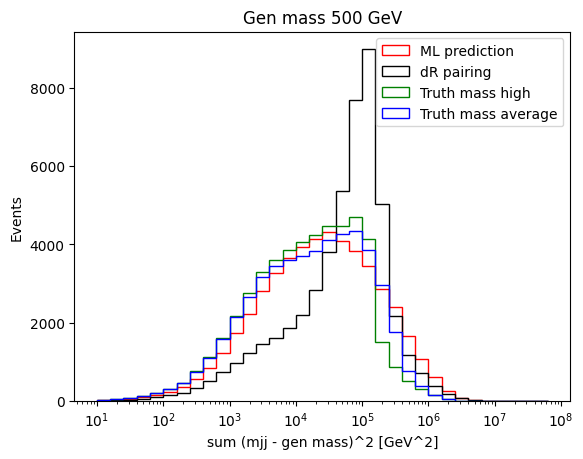

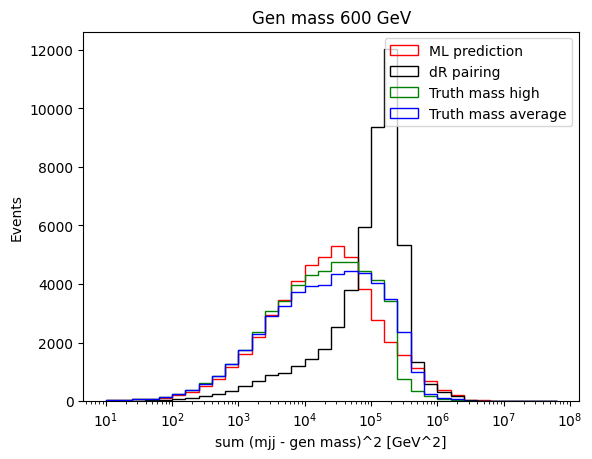

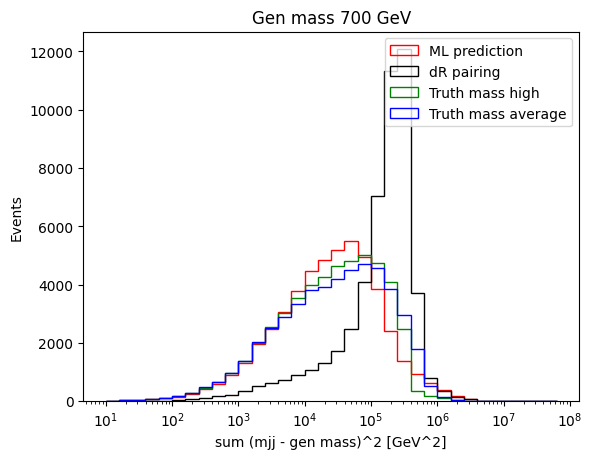

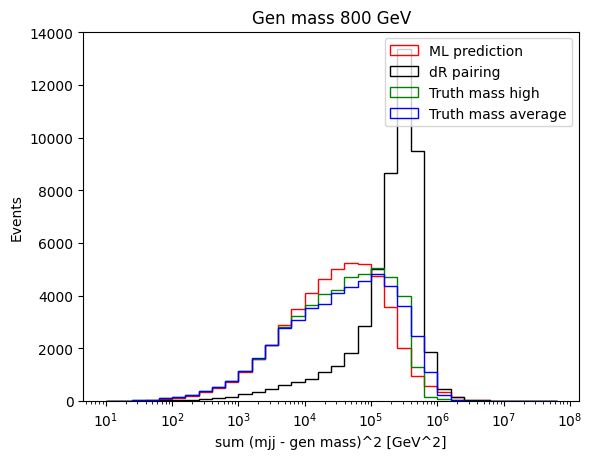

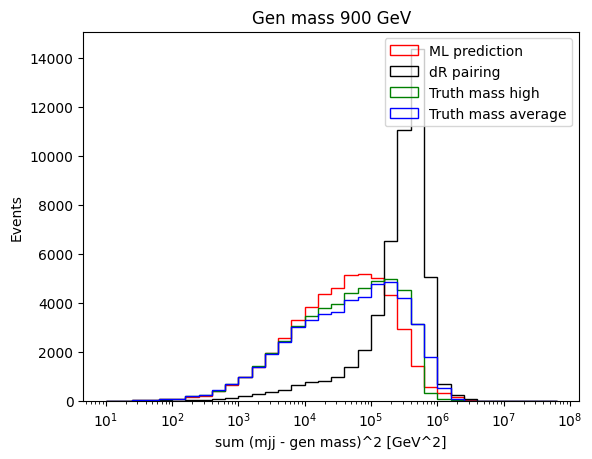

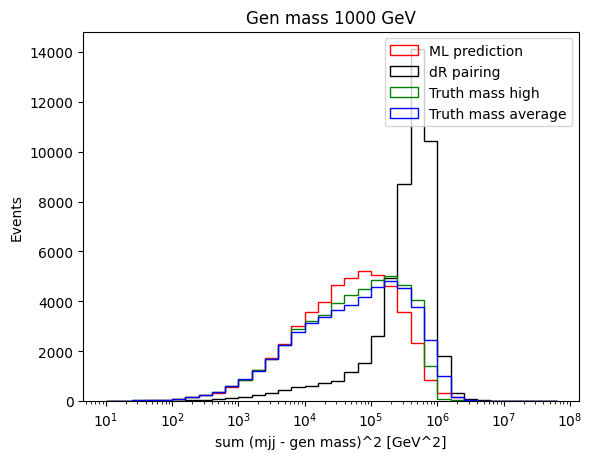

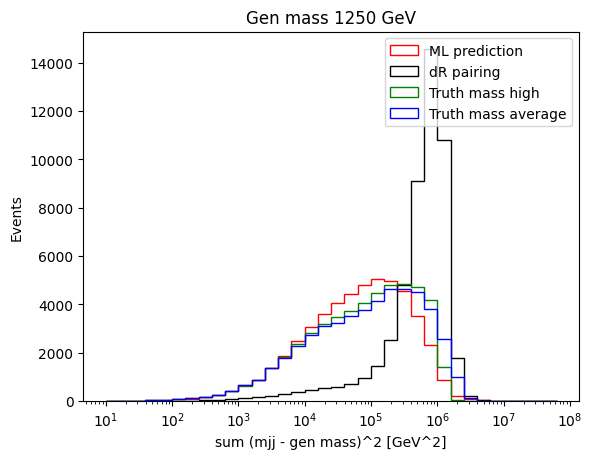

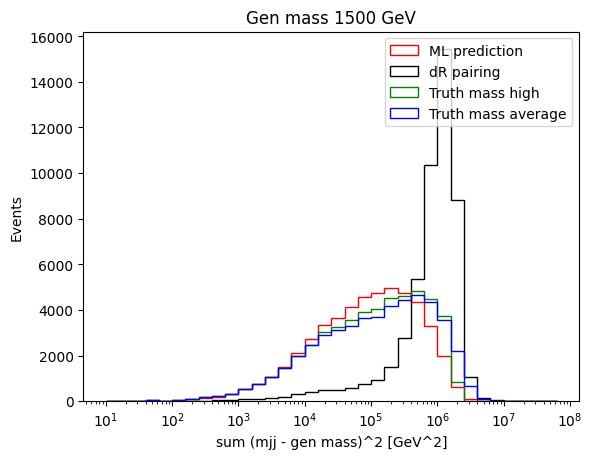

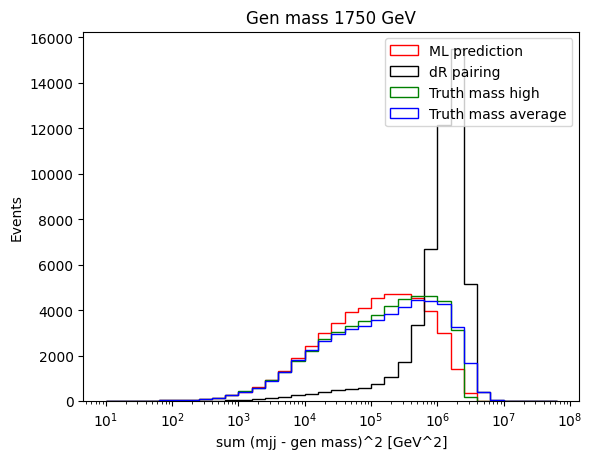

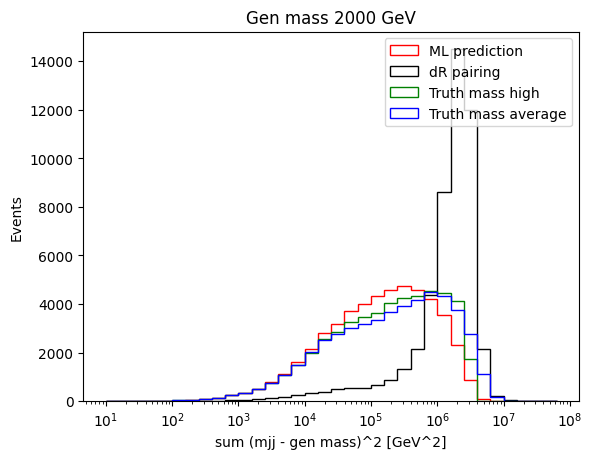

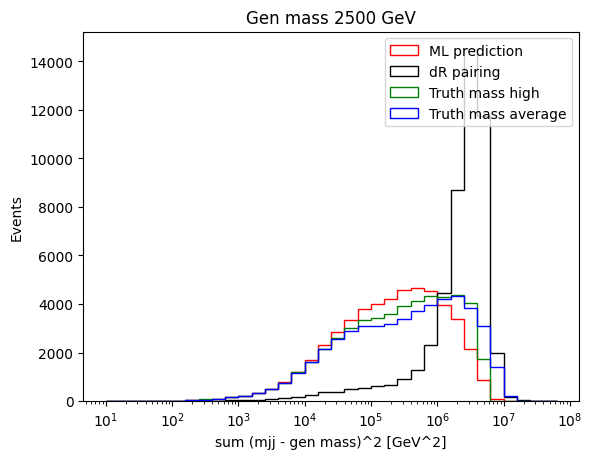

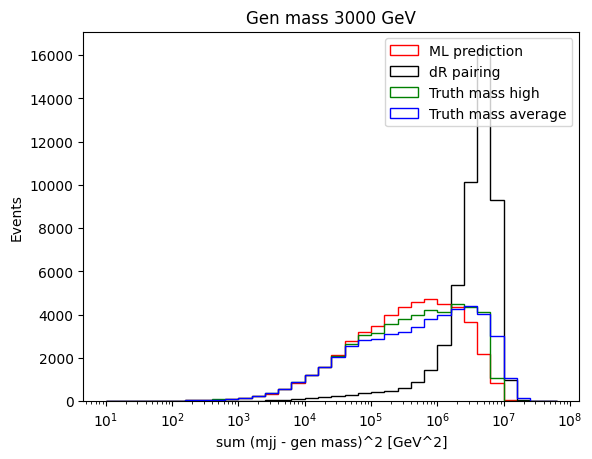

In [35]:
# for each gen mass sample, plot sum (mjj - gen mass)^2
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    Bins = [10**(x/5) for x in range(5,40)]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_QSMD"], bins = Bins,
             histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_QSMD"], bins = Bins,
             histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_QSMD"], bins = Bins,
             histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_QSMD"], bins = Bins,
             histtype = "step", color = "b", label = "Truth mass average")
    plt.xscale('log')
    plt.legend()
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("sum (mjj - gen mass)^2 [GeV^2]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Quad_sum_mass_diff_" + str(Mass) + "GeV.png")

In [36]:
TestingDF["Pred_M_high_div_M4j"] = TestingDF["Pred_M_high"] / 1000 / TestingDF["fourjetmasstev"]
if SanityCheckPlots:
    plt.hist2d(TestingDF["fourjetmasstev"], TestingDF["Pred_M_high_div_M4j"],
               bins = 200, range = [[0.5,10], [0.2,0.65]], norm = "log")
    plt.xlabel("fourjetmasstev")
    plt.ylabel("Pred_M_high_div_M4j")
    plt.colorbar()
    plt.savefig(ResultsDir + "Pred_M_high_div_M4j_vs_M4j.png")

In [37]:
if SanityCheckPlots:
    for i, Mass in enumerate(Masses):
        TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
        if len(TestingDF_temp.index) == 0: continue
        
        plt.figure()    
        plt.hist2d(TestingDF_temp["fourjetmasstev"], TestingDF_temp["Pred_M_high_div_M4j"],
                   bins = 200, range = [[Mass/1000.0, Mass/1000.0 + 3 + 0.4*i], [0.25,0.65]], norm = "log")
        plt.title("Gen mass " + str(Mass) + " GeV")
        plt.xlabel("fourjetmasstev")
        plt.ylabel("Pred_M_high_div_M4j")
        plt.colorbar()
        plt.savefig(ResultsDir + "Pred_M_high_div_M4j_vs_M4j_" + str(Mass) + "GeV.png")